In [1]:
!git clone https://github.com/wkentaro/gdown
!cd gdown
!pip install gdown

Cloning into 'gdown'...
remote: Enumerating objects: 845, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 845 (delta 11), reused 9 (delta 4), pack-reused 820
Receiving objects: 100% (845/845), 639.46 KiB | 1.72 MiB/s, done.
Resolving deltas: 100% (472/472), done.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-3.13.0-py3-none-any.whl size=9034 sha256=505a195f612d8a141198951d9d354ef10841431ce66789ff87ce7252e668c696
  Stored in directory: /root/.cache/pip/wheels/2f/2a/2f/86449b6bdbaa9aef873f68332b68be6bfbc386b9219f47157d
Successfully built gdown


对神经网络进行攻击，即希望在图片中稍微加入一些人眼不易观察到的杂讯，从而使CNN的输出为完全不同的结果，从而“骗”过CNN

在这里，我们选择的是vgg16

本实验中的方法FGSM

paper:https://arxiv.org/abs/1412.6572


In [2]:
# 下載資料
!gdown --id '14CqX3OfY9aUbhGp4OpdSHLvq2321fUB7' --output data.zip
# 解壓縮
!unzip -qq -u data.zip
# 確認目前的檔案
!ls

Downloading...
From: https://drive.google.com/uc?id=14CqX3OfY9aUbhGp4OpdSHLvq2321fUB7
To: /kaggle/working/data.zip
17.9MB [00:00, 41.8MB/s]
__notebook_source__.ipynb  data  data.zip  gdown


In [3]:
import os
import pandas as pd
from PIL import Image
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader

import torchvision.models as models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

device = torch.device('cuda')

In [16]:
class Adverdataset(Dataset):
    def __init__(self, root, label, transforms):
        self.root = root
        self.label = torch.from_numpy(label).long()
        self.transforms = transforms
        self.fnames = []

        for i in range(200):
            self.fnames.append('{:03d}'.format(i))

    def __getitem__(self,idx):
        img = Image.open(os.path.join(self.root, self.fnames[idx]+'.png'))
        img = self.transforms(img)
        label = self.label[idx]
        return img, label
    
    def __len__(self):
        return 200

In [19]:
class Attacker:
    def __init__(self, img_dir, label):
        self.model = models.vgg16(pretrained = True)
        self.model.cuda()
        self.model.eval()
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.292, 0.224, 0.225]
        self.normalize = transforms.Normalize(self.mean, self.std, inplace=False)
        self.transform = transforms.Compose([
            transforms.Resize((224, 224), interpolation=3),
            transforms.ToTensor(),
            self.normalize
        ])

        self.dataset = Adverdataset('./data/images', label, self.transform)

        self.loader = torch.utils.data.DataLoader(
            self.dataset,
            batch_size = 1,
            shuffle = False
        )

    def fgsm_attack(self, image, epsilon, data_grad):
        sign_data_grad = data_grad.sign()
        perturbed_image = image + epsilon*sign_data_grad
        return perturbed_image

    def attack(self, epsilon):
        adv_examples = []
        wrong, fail, success = 0, 0, 0
        for (data, target) in self.loader:
            data, target = data.to(device), target.to(device)
            data_raw = data
            data.requires_grad = True

            output = self.model(data)
            init_pred = output.max(1, keepdim=True)[1]

            # 如果模型本身就对图片识别错误，那么就不进行攻击，因为模型本来就没有认出来
            if init_pred.item() != target.item():
                wrong += 1
                continue

            # 如果模型本身对图片识别正确，那么就进行攻击
            loss = F.nll_loss(output, target)
            self.model.zero_grad() # 在攻击过程中model的参数是不发生变化的，所以它不进行反向传播
            loss.backward()
            data_grad = data.grad.data # 记录下对image的梯度
            perturbed_data = self.fgsm_attack(data, epsilon, data_grad)  # 进行fgsm攻击

            # perturbed_data是调整后的image，再次输入model进行预测
            output = self.model(perturbed_data)
            final_pred = output.max(1, keepdim=True)[1]

            if final_pred.item() == target.item():
                fail += 1
            else:
                # 如果攻击成功的话就将调整后的image存下来
                success += 1
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data*torch.tensor(self.std, device=device).view(3,1,1)+torch.tensor(self.mean, device=device).view(3,1,1)
                    adv_ex = adv_ex.squeeze().detach().cpu().numpy()
                    data_raw = data_raw*torch.tensor(self.std, device=device).view(3,1,1)+torch.tensor(self.mean, device=device).view(3,1,1)
                    data_raw = data_raw.squeeze().detach().cpu().numpy()

                    adv_examples.append((init_pred.item(), final_pred.item(), data_raw, adv_ex))
        final_acc = (fail / (wrong+success+fail))
        print('epsilon: {}\t Test accuracy={}/{} = {} \n'.format(epsilon, fail, len(self.loader), final_acc))
        return adv_examples, final_acc

In [21]:
if __name__ == '__main__':
    df = pd.read_csv('./data/labels.csv')
    df = df.loc[:, 'TrueLabel'].to_numpy()
    label_name = pd.read_csv('./data/categories.csv')
    label_name = label_name.loc[:, 'CategoryName'].to_numpy()
    attacker = Attacker('./data/images', df)

    epsilons = [0.1, 0.01]
    accuracies, examples = [], []

    for eps in epsilons:
        ex, acc = attacker.attack(eps)
        accuracies.append(acc)
        examples.append(ex)

epsilon: 0.1	 Test accuracy=3/200 = 0.015 

epsilon: 0.01	 Test accuracy=48/200 = 0.24 



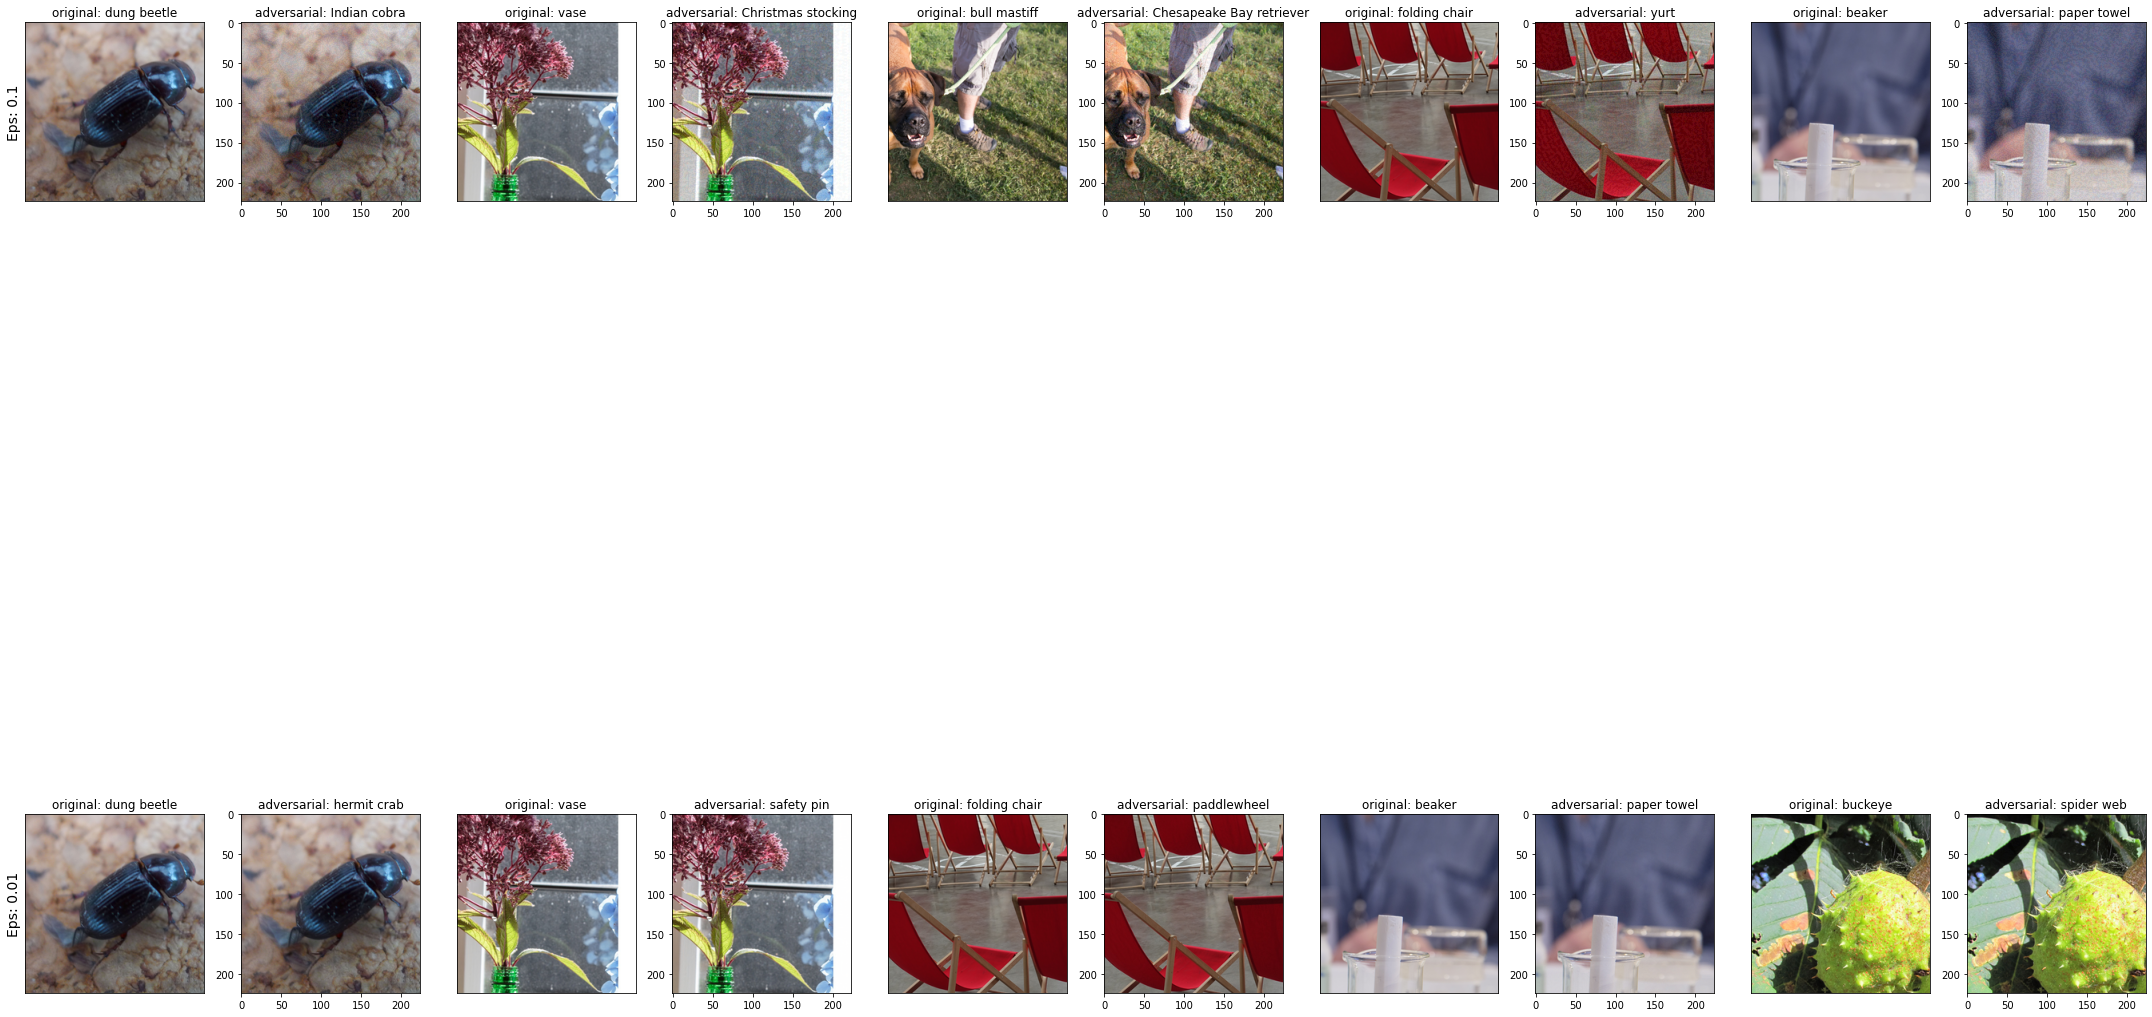

In [24]:
cnt = 0
plt.figure(figsize=(30,30))

for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(examples[0])*2, cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel('Eps: {}'.format(epsilons[i]), fontsize=14)
        orig, adv, orig_img, ex = examples[i][j]
        plt.title('original: {}'.format(label_name[orig].split(',')[0]))
        orig_img = np.transpose(orig_img, (1, 2, 0))
        plt.imshow(orig_img)
        cnt += 1
        plt.subplot(len(epsilons), len(examples[0])*2, cnt)
        plt.title('adversarial: {}'.format(label_name[adv].split(',')[0]))
        ex = np.transpose(ex, (1, 2, 0))
        plt.imshow(ex)
plt.tight_layout()
plt.show()